# 04 - Applied ML

# Imports

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

%matplotlib inline

# Constants definition

In [2]:
DATA_PATH = "./data"

 # Question 1: Propensity score matching

In [ ]:
df = pd.read_csv("{}/lalonde.csv".format(DATA_PATH))
df.set_index('id', drop=True, inplace=True)

In [ ]:
df['outcome'] = np.where( (df['re78'] - df['re75']) > 0 , 1, 0)

In [ ]:
df.head()

In [ ]:
df[['educ', 'outcome', 'treat']].groupby(['educ', 'outcome']).count()

### 1. a naive approach

In [ ]:
x = df[df["treat"] == 0]['re74']
y = df[df["treat"] == 0]['re78']

plt.hist( (x, y), label=('Before treatment', 'After treatment'))
plt.legend(loc='upper right')
plt.title("People NOT under treatment")
plt.show()

In [ ]:
x = df[df["treat"] == 1]['re74']
y = df[df["treat"] == 1]['re78']

plt.hist( (x, y), label=('Before treatment', 'After treatment'))
plt.legend(loc='upper right')
plt.title("People under treatment")
plt.show()

### 3. A propensity score model

In the propensity score we want to obtain the probability to be under treatment according to the different covariates. In this case we will use the Logistic Regression Classifier to obtain a model for such task

In [ ]:
logistic = LogisticRegression()

The differen covariates of this problem are the following:

In [ ]:
features = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree']

In [ ]:
# The features vector
X = pd.get_dummies(df[features])
X.head()

We want to compute the probability of the treatment over the covariates. Our target will therefore be the treatment data

In [ ]:
y = df['treat']

In [ ]:
logistic.fit(X, y)

In [ ]:
logistic.classes_

In [ ]:
pred = logistic.predict_proba(X)

df['propensity score'] = pred[:, 1]

df.head()

### 4. Balancing the dataset via matching

In [ ]:
G = nx.Graph()
G.add_nodes_from([1,2,3,4], bipartite=0) # Add the node attribute "bipartite"
G.add_nodes_from(['a','b','c'], bipartite=1)
G.add_edges_from([(1,'a'), (1,'b'), (2,'b'), (2,'c'), (3,'c'), (4,'a')])

In [ ]:
treated = df[df['treat'] == 1]['propensity score']
control = df[df['treat'] == 0]['propensity score']

In [ ]:
B = nx.Graph()

B.add_nodes_from(treated[:5], bipartite=0)
B.add_nodes_from(control[:5], bipartite=1)

In [ ]:
plt.subplot(121)
nx.draw(B, with_labels=True, font_weight='regular')

In [ ]:
from networkx.algorithms import bipartite
a, b = bipartite.sets(B)

In [ ]:
a

In [ ]:
nx.bipartite.maximum_matching(B)

 # 2 Applied ML

### 2.1 Load the 20newsgroup dataset, get textual features and split data

We start by loading the dataset. The data is loaded in an object type `sklearn.utils.Bunch`, which is a dictionary-like object. The interesting attributes (or *keys* of this object) are:
* `data`: The data to learn. As shown, there are 18846 samples in the entire dataset that we will split into training, test and validation.
* `target`: The classification labels.
* `target_names`: The 20 different labels.

In [3]:
newsgroups = fetch_20newsgroups(data_home='{}/'.format(DATA_PATH),
    subset='all')

In [4]:
newsgroups.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

In [5]:
len(newsgroups.data)

18846

We now use `sklearn` and compute the textual features with `TfidfVectorizer`. We only compute 6000 features so that it doesn't take so long to train the model afterwards.

In [6]:
vectorizer = TfidfVectorizer(max_features=6000)
vectors = vectorizer.fit_transform(newsgroups.data)

Next, we split into training, test and validation sets. The size of the test and validation sets will be of 10% of the total each, and we will train on the remaining 80%.

To do it we first generate a permutation of the indices of the data entries. Then we keep the first 10% for validation, and out of the remaining 90% we use 10% for test and the rest for training. We use these indices to split both the features `x` and the classification labels `y`.

In [9]:
# We define 'x' (textual features) and 'y' (classification labels)
x = vectors
y = newsgroups.target

# We set a random seed for reproducibility
np.random.seed(512)
ratio = .1


x_all, x_val, y_all, y_val = train_test_split(x, y, test_size=ratio, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=ratio, random_state=42)

### 2.2 Train a random forest and assess the model

We will now train a random forest on the training set.

We need to choose the parameters `n_estimators` and `max_depth`, which we will do by using grid-search.

For this we define two auxiliary functions. The first function (`grid_search`) iterates over the vectors of values for the two parameters, and calls the function `r_forest_accuracy` to compute the accuracy of the classification for each pair of parameters. We chose the ranges of the parameters so that we could try several combinations of them, but stopped at the point where the computation time was too long.

It is worth to emphasize that we will train the random forest over the training set, and then compute the accuracy over the test set. We will then keep the pair of parameters that achieved a highest accuracy for the test set.

Lastly, we will assess our model by using the samples in the validation test.

In [13]:
def grid_search(x_train, y_train, x_test, y_test, n_estimators_s, max_depth_s):
    """Algorithm for grid search."""
    accuracies = np.zeros((len(n_estimators_s), len(max_depth_s)))

    for i in range(len(n_estimators_s)):
        for j in range(len(max_depth_s)):
            accuracies[i][j] = r_forest_accuracy(x_train, y_train, x_test, y_test,
                n_estimators_s[i], max_depth_s[j])
    return accuracies

In [14]:
def r_forest_accuracy(x_train, y_train, x_test, y_test, n_estimators, max_depth):
    # Build the random forest classifier
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=0,
        n_jobs=-1)
    
    # Fit the model to the training data 
    clf.fit(x_train, y_train)
    
    # Obtain predictions for test set
    y_pred = clf.predict(x_test)
    
    # Calculate accuracy
    return np.sum(y_test == y_pred)/len(y_test)

In [17]:
n_estimators_s = np.arange(60, 240, 30)
max_depth_s = np.arange(30, 240, 30)

accuracies = grid_search(x_train, y_train,
    x_test, y_test,
    n_estimators_s, max_depth_s)

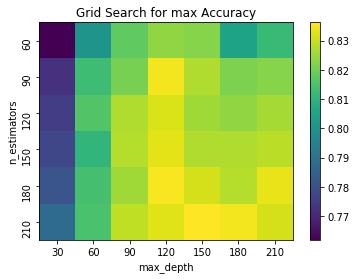

In [18]:
plt.imshow(accuracies)
plt.colorbar()
plt.title('Grid Search for max Accuracy')
plt.ylabel('n_estimators')
plt.xlabel('max_depth')
tick_marks_x = np.arange(len(max_depth_s))
tick_marks_y = np.arange(len(n_estimators_s))
plt.yticks(tick_marks_y, n_estimators_s, rotation=90)
plt.xticks(tick_marks_x, max_depth_s)
plt.show()

We can see that the pair of parameters that gives us the best result is `n_estimators=210` and `max_depth=150`. The accuracy obtained with these parameters is 0.83618.

We will now try to improve the accuracy by focusing the grid search on the parameters range that achieve highest accuracies. 

In [23]:
n_estimators_s = np.arange(150, 270, 30)
max_depth_s = np.arange(120, 240, 30)

accuracies_improved = grid_search(x_train, y_train,
    x_test, y_test,
    n_estimators_s, max_depth_s)

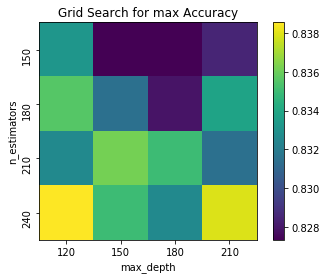

In [24]:
plt.imshow(accuracies_improved)
plt.colorbar()
plt.title('Grid Search for max Accuracy')
plt.ylabel('n_estimators')
plt.xlabel('max_depth')
tick_marks_x = np.arange(len(max_depth_s))
tick_marks_y = np.arange(len(n_estimators_s))
plt.yticks(tick_marks_y, n_estimators_s, rotation=90)
plt.xticks(tick_marks_x, max_depth_s)
plt.show()

The best result is achieved with `n_estimators=240` and `max_depth=120`. The accuracy obtained with these parameters is 0.838538.

In [27]:
clf = RandomForestClassifier(
    n_estimators=240,
    max_depth=120,
    random_state=0,
    n_jobs=-1)
    
# Fit the model to the training data 
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=120, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=240, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Now we will obtain the predictions for the validation set. We will compare these predictions with the classification labels, and build the confusion matrix for the chosen model. 

The function for plotting the confusion matrix was found [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).

In [28]:
# Compute predictions for validation set
y_pred = clf.predict(x_val)

# Build confusion matrix
cnf_matrix = metrics.confusion_matrix(y_val, y_pred)

In [29]:
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    #print('Confusion matrix, without normalization')
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

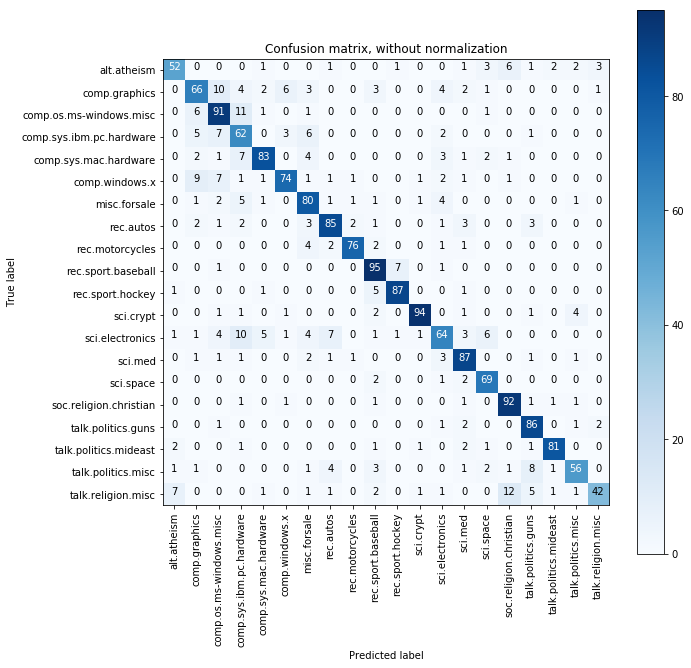

In [30]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=newsgroups.target_names, title='Confusion matrix, without normalization')

We can see from the confusion matrix that overall the classification works properly, since the elements in the diagonal have higher values than the other elements. However, it is noticeable that some of the news labelled as `talk.religion.misc` have been mislabelled as `soc.religion.christian`.  

Lastly, we will inspect the `feature_importances_` attribute of the random forest.

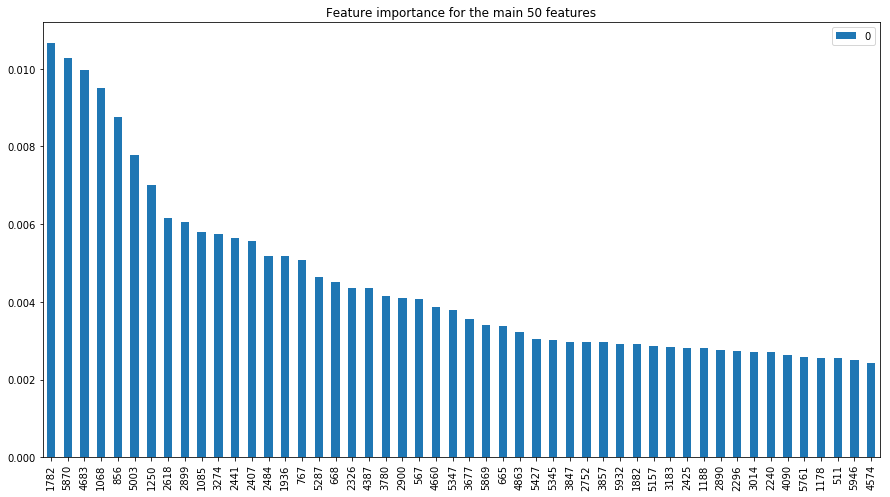

In [31]:
#Create dataframe with features ordered according to importance
feature_importances_df = pd.DataFrame(clf.feature_importances_).sort_values(by=0, ascending=False)

# Plot 50 most important features
feature_importances_df.head(50).plot(y=0, kind='bar', figsize=(15,8),
    title='Feature importance for the main 50 features')

In the previous plot we can see that the feature importance is higher for the first 25 features aproximately, and then slowly decreases for the remaining ones (they have been ommitted from the plot for more clarity, since it did not give important information to the reader). This suggests that if we needed to reduce the number of features, we could have kept only the first 25 ones, or even only the first 16.